# Abilità Informatiche e Telematiche a.a. 2022-2023 
## Esercizio finale (di Giuseppe Cipolla)

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
# Verifico di essere nella directory giusta 
!pwd

/mnt/c/Users/giuse/Desktop/LM-17 FISICA TEORICA/ANNO 1 SEM 1/A - AbInfo2223/AAA-ProgettoEsame


## 0. Come maneggiare data file

In [3]:
fname= 'data/MockMeasures_2PCF_Test1/MockMeasures_2PCF_Correlation_MULTIPOLES_Test1_1.fits'
file = fits.open(fname)

In [4]:
file

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fba66872670>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fba91cc54f0>]

In [5]:
file[0].header # caratteristiche file

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

In [6]:
file[1].header # info sul contenuto dei dati

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   48 / width of table in bytes                        
NAXIS2  =                  200 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    6 / number of fields in each row                   
EXTNAME = 'CORRELATION'        / name of this binary table extension            
DATE    = '2021-10-11T15:20:58' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
CHECKSUM= '11PD40N910NC10N9'   / HDU checksum updated 2021-10-11T15:20:58       
DATASUM = '3493986317'         / data unit checksum updated 2021-10-11T15:20:58 
TELESCOP= 'EUCLID  '        

In [7]:
file[1].data # dati veri e propri

FITS_rec([(  0.59975,  8.54205150e+00, 0., -3.44217353e+00, 0., -3.05878863e+00),
          (  1.59925,  2.89127955e+00, 0., -5.54919428e-01, 0., -8.97318156e-01),
          (  2.59875,  1.51079053e+00, 0., -2.18552188e-01, 0., -3.49992133e-01),
          (  3.59825,  9.58324561e-01, 0., -1.17000828e-01, 0., -1.31833928e-01),
          (  4.59775,  6.68471660e-01, 0., -8.96877154e-02, 0., -1.52346569e-01),
          (  5.59725,  4.98214450e-01, 0., -9.94204219e-02, 0., -9.31585195e-02),
          (  6.59675,  3.90214392e-01, 0., -2.82246323e-02, 0., -5.29329306e-02),
          (  7.59625,  2.99754650e-01, 0., -6.91685268e-02, 0., -8.83656107e-02),
          (  8.59575,  2.49860708e-01, 0., -4.73030365e-02, 0., -5.44634927e-02),
          (  9.59525,  1.97435768e-01, 0., -6.22467439e-02, 0., -8.51734824e-02),
          ( 10.59475,  1.75106286e-01, 0., -4.41889582e-02, 0., -4.15635943e-02),
          ( 11.59425,  1.41045038e-01, 0., -3.94166804e-02, 0., -3.87499395e-02),
          ( 12.5

In [13]:
file[1].data.shape              # restituisce (200,)
print(file[1].data[0])

(0.59975, 8.542051499140822, 0.0, -3.4421735297033274, 0.0, -3.0587886313819728)


## 1. Estraggo dati di singolo multipolo 'XI0' da Test 1

In [58]:
# LETTURA
Nbins=200 # length vettore di dati
Nmeasures=100 # può arrivare a 10000; POI METTO A  1000!
test=1
measures=[] # LISTA, vuota
for i in np.arange(Nmeasures)+1: # da 0 a N-1, ma se metto "+1", va da 1 a N!
    fname = f'data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    #print(f'apro il file N.{i} chiamato {fname}')
    
    file = fits.open(fname)
    table = file[1].data.copy()
    measures.append(table['XI0']) # estrai colonna XI0 dalla tabella
    if i==1:
        scale = table['SCALE']    # estrai colonna SCALE della tabella
    del table
    file.close()
    
#trasformiamo lista in array numpy (-> matrice!)   
measures=np.asarray(measures)

In [59]:
#measures
measures.shape # dimensioni della matrice nrowsXncols

(100, 200)

## 2. Calcolo matrice di covarianza misurata
In breve, usa: `cov_ij = cov(np.transpose(measures))`

Supponendo di stare considerando uno specifico multipolo $l$ [qui monopolo: estraiamo XI0!], la covarianza numerica del multipolo $l$ calcolato in punti diversi $i,j$ è
$$
C^{(\text{exp})}_{i,j}=\frac{1}{N_{\text{sim}}-1}\sum_{n=1}^{N_{\text{sim}}} (D^{(n)}_i-\bar{D}_i)(D^{(n)}_j-\bar{D}_j),
$$
dove $D_i^{(n)}$, multipolo $(l)$-esimo calcolato nel bin $i$-esimo(finita risoluzione spaziale) per il set $n$-esimo di misure

### 2.1. Conto esplicito

#### Prove preliminari

In [17]:
cov_matrix = np.zeros((Nbins,Nbins))          #initialization of covariance matrix
cov_matrix.shape

for i in np.arange(len(measures[0,:])):
    for j in np.arange(len(measures[0,:])):
        c_ij = 0.
        mean_i = np.mean(measures[:,i]) # \bar{D}_i
        mean_j = np.mean(measures[:,j]) # \bar{D}_j
        for n in np.arange(Nmeasures):
            c_ij = c_ij + (measures[n,i]-mean_i)*(measures[n,j]-mean_j)
        c_ij = c_ij/(Nmeasures-1)
        cov_matrix[i,j] = c_ij
            

Ora visualizziamo la matrice ci covarianza ottenuta:

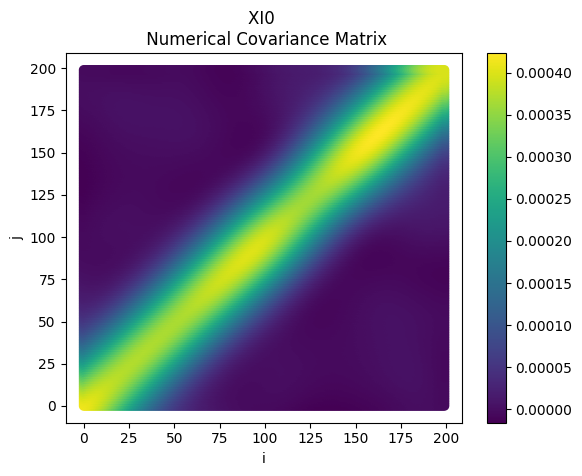

In [18]:
#plotting covariance matrix
x,y = np.meshgrid(range(cov_matrix.shape[0]),range(cov_matrix.shape[1]))
plt.xlabel('i')
plt.ylabel('j')
plt.scatter(x,y,c=cov_matrix[x,y],label='CovMatrix')
plt.title('XI0 \n Numerical Covariance Matrix')
plt.colorbar()  
save=False      
if save: plt.savefig('bello', dpi=200)
    #plt.show()

#### Risultato

In [19]:
def HomeMade_NumericalCovMatrix(Nbins, measures):
    '''
    Calcola la matrice di covarianza numerica.
    
    Args:
        Nbins (int): number of different entries of the Covariance (square) matrix
        measures (array(Nsim,Nbins)): measures, where 2nd index stays for the specific bin-observable  
    
    
    Returns:
        cov_matrix(array (Nbins,Nbins)): (c_ij), with i,j=1,...Nbins
        
    '''
    cov_matrix = np.zeros((Nbins,Nbins))          #initialization of covariance matrix
    for i in np.arange(len(measures[0,:])):
        for j in np.arange(len(measures[0,:])):
            c_ij = 0.
            mean_i = np.mean(measures[:,i]) # \bar{D}_i
            mean_j = np.mean(measures[:,j]) # \bar{D}_j
            for n in np.arange(Nmeasures):
                c_ij = c_ij + (measures[n,i]-mean_i)*(measures[n,j]-mean_j)
            c_ij = c_ij/(Nmeasures-1)
            cov_matrix[i,j] = c_ij
            
    return cov_matrix

def plot_Matrix(matrix, title='XI0 \n Numerical Covariance Matrix', save=False, fname='XI0CovMatrix'):
    """Plot di matrice delle covarianze (o delle correlazioni)

    Args:
        matrix (array(Nbins,Nbins)): (c_ij)
        title (str, optional): Titolo del plot. Defaults to 'XI0 \n Numerical Covariance Matrix'.
        save (bool, optional): Se 'True' sava figura in formato pdf. Defaults to False.
        fname (str, optional): Nome dell'eventuale file pdf di salvataggio. Defaults to 'XI0CovMatrix'.
    """    
    x,y = np.meshgrid(range(matrix.shape[0]),range(matrix.shape[1]))
    plt.xlabel('i')
    plt.ylabel('j')
    plt.scatter(x,y,c=matrix[x,y],label='CovMatrix')
    plt.title(title)
    plt.colorbar()       
    if save: plt.savefig(fname, dpi=200)
    

In [26]:
HomeMade_Cov_matrix = HomeMade_NumericalCovMatrix(Nbins,measures)

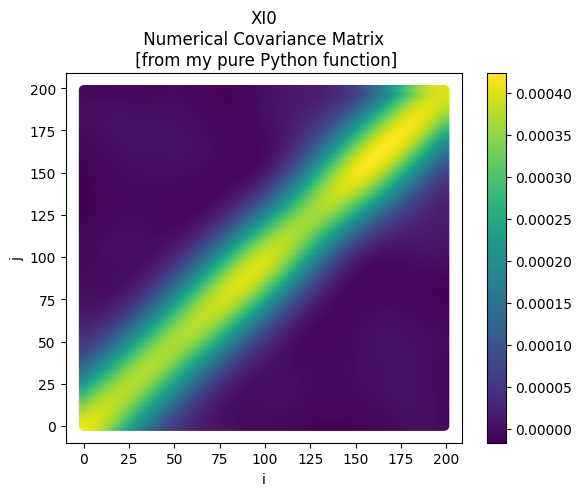

In [27]:
plot_Matrix(HomeMade_Cov_matrix,title = 'XI0\n Numerical Covariance Matrix \n [from my pure Python function]')

### 2.1. Uso delle librerie (NumPy)

Dal confronto con conto fatto sopra, verifichiamo che
> `cov_ij=np.cov(np.transpose(measures))`

 produce correttamente (e più velocemente!) la matrice di covarianza (campionaria) cercata.\
 **NB**. Fin qui matrice di correlazione entro stesso multipolo XIO.

Usiamo la funzione numpy `numpy.cov()`

In [23]:
import numpy as np
Numpy_CovMatrix = np.cov(np.transpose(measures))

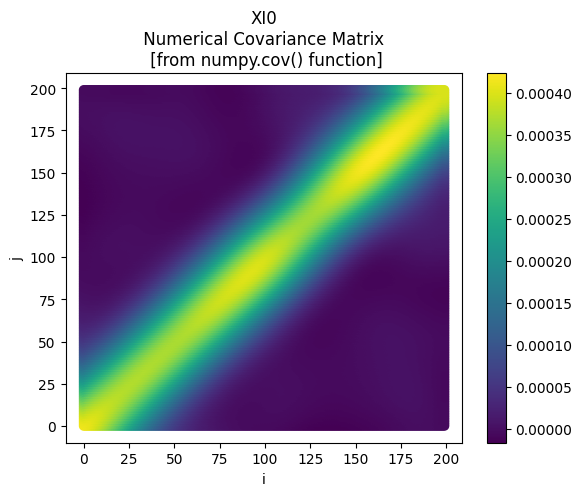

In [24]:
plot_Matrix(Numpy_CovMatrix, title = 'XI0\n Numerical Covariance Matrix \n [from numpy.cov() function]' )

In [28]:
#tmp = Numpy_CovMatrix-HomemadeCov_matrix
#plot_CovMatrix(tmp) # circa zero matrix, OK
print('Largest deviation between my calculation and numpy: {}'.format(np.max(np.abs(Numpy_CovMatrix-HomeMade_Cov_matrix))))

Largest deviation between my calculation and numpy: 1.2468324983583301e-18


### 2.2. Uso finale

In [60]:
import numpy as np
cov_xi = np.cov(np.transpose(measures))

### 2.3.  Matrice di correlazione numerica
La matrice di correlazione è la matrice di covarianza normalizzata ad $1$ sulla diagonale, i.e.
$$
R_{ij}=\frac{C_{ij}}{\sqrt{C_{ii}C_{jj}}}.
$$

In [37]:
# correlation matrix
corr_xi = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        corr_xi[i,j]=Numpy_CovMatrix[i,j]/(Numpy_CovMatrix[i,i]*Numpy_CovMatrix[j,j])**0.5

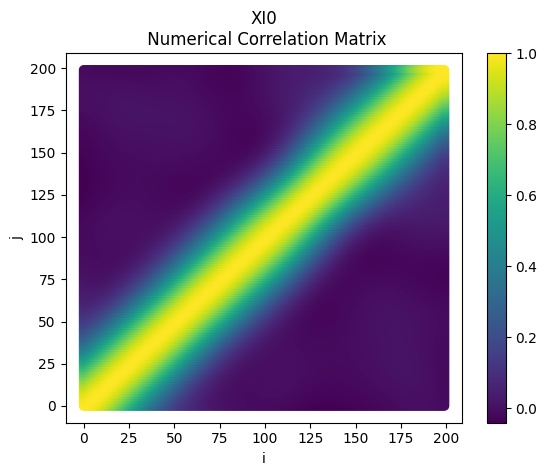

In [38]:
plot_Matrix(corr_xi,title = 'XI0\n Numerical Correlation Matrix')

## 3. Calcolo matrice di covarianza teorica e matrice dei residui

La covariaza teorica è della forma:
$$
C^{\text{(th)}}_{ij}\equiv C^{\text{th}}[D_l(r_i),D_{l'}(r_j)]:=\sigma_l\sigma_{l'}\sqrt{\frac{2h_lh_{l'}}{h_l^2+h^2_{l'}}}\cdot\text{exp}\Big[-\frac{(r_i-r_j)^2}{h_l^2+h^2_{l'}}\Big]
$$
I residui (non normalizzati) sono definiti come:
$$
\text{Res}_{ij}:=C^{(th)}_{ij}-C^{(exp)}_{ij}
$$

In [61]:
if test==1:
    sigs = [0.02, 0.02, 0.02]
    ls = [25, 50, 75]
elif test==2:
    sigs = [0.02, 0.01, 0.005]
    ls = [50, 50, 50]
else:
    sigs = [0.02, 0.01, 0.005]
    ls = [5, 5, 5]

In [62]:
## Definitions to build the covarince matrices based on Squared Exponential kernel
def covf(x1, x2, sig, l):
    return sig**2.*np.exp(-(x1 - x2)**2./(2.*l**2.))

def covf1f2(x1, x2, sig1, l1, sig2, l2):
    return (np.sqrt(2.*l1*l2)*np.exp(-(np.sqrt((x1 - x2)**2.)**2./(l1**2. + l2**2.)))*sig1*sig2)/np.sqrt(l1**2. + l2**2.)

In [63]:
cov_th = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th[i,j] = covf(scale[i],scale[j],sigs[0],ls[0])

In [35]:
PLOTS=True

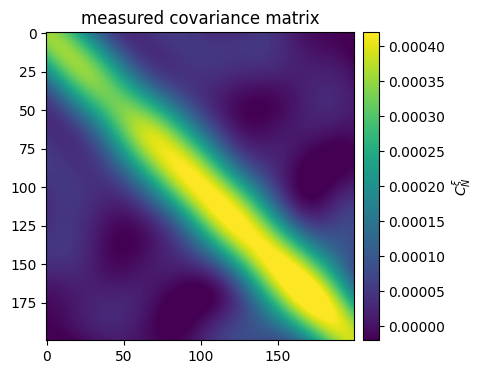

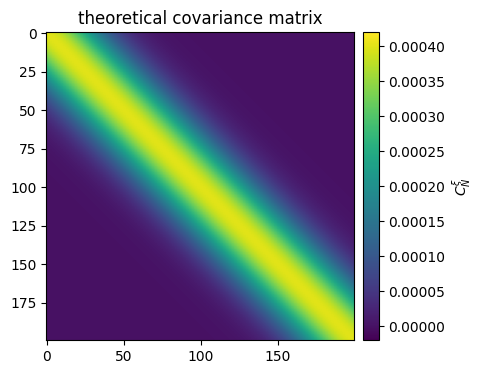

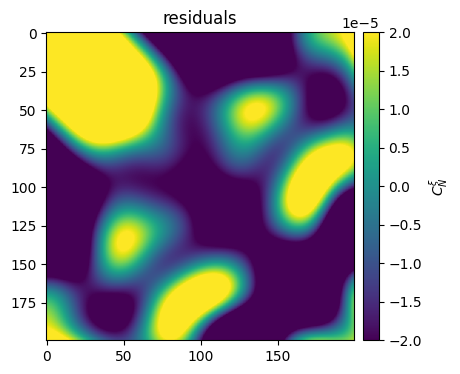

In [64]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th)*0.05
    cmax =  np.max(cov_th)*1.05

    # Matrix plot of measured covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('measured covariance matrix')
    plt.imshow(cov_xi, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()


    # Matrix plot of theoretical covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('theoretical covariance matrix')
    plt.imshow(cov_th, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Matrix plot of theoretical covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('residuals')
    plt.imshow(cov_th-cov_xi, vmin=cmin, vmax=-cmin)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

## 4. Deviazione standard dei residui normalizzati

I residui normalizzati sono della forma:
$$
\text{(Norm. Res)}_{ij}:=(C^{(th)}_{ij}-C^{(exp)}_{ij})\sqrt{\frac{N_{\text{sim}}-1}{(1+R_{ij}^{(th)})C_{i,i}^{(th)}C_{j,j}^{(th)}}} \sim \mathcal{N}(\mu=0,\sigma^2=1)
$$

In [74]:
norm_residuals = np.zeros_like(cov_th)
for i in range(Nbins):
    for j in range(Nbins):
        rho = cov_th[i,j]/(np.sqrt(cov_th[i,i]*cov_th[j,j]))
        norm_residuals[i,j]=(cov_th[i,j]-cov_xi[i,j])*np.sqrt((Nmeasures-1.)/((1.+rho)*cov_th[i,i]*cov_th[j,j]))

rms_deviation=np.std(norm_residuals.reshape(Nbins**2),ddof=1)

print(f"rms deviation of normalized residuals: {rms_deviation}")

if rms_deviation<1.1:
    print("**********")
    print("* PASSED *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! FAILED !")
    print("!!!!!!!!!!")

rms deviation of normalized residuals: 0.6238236546025828
**********
* PASSED *
**********


Avendo verificato che la varianza campionaria dei residui normalizzati è compatibile con l'aspettativa teorica di distribuzione normale standard per i residui normalizzati, concludiamo che il test di validazione è stato superato con successo.